In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import math
from datetime import datetime as dt
from IPython.display import Image, HTML

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import seaborn as sns


In [2]:
def create_dates(start,days):
    v = pd.date_range(start=start, periods=days+1, freq='H', closed='right')
    seven_day_forecast = pd.DataFrame(index=v) 
    return seven_day_forecast

In [3]:
# get values, station name and drop null values
def get_value_name(all_station_temp,i):
    station_value = all_station_temp[[all_station_temp.columns[i]]].dropna()
    station_name = all_station_temp.columns[i]
    return station_value, station_name 

In [4]:
# train-test split for a user input ratio
def train_test_split(value, name, ratio):
    nrow = len(value)
    print(name+' total samples: ',nrow)
    split_row = int((nrow)*ratio)
    print('Training samples: ',split_row)
    print('Testing samples: ',nrow-split_row)
    train = value.iloc[:split_row]
    test = value.iloc[split_row:]
    return train, test, split_row     

In [5]:
# data transformation
def data_transformation(train_tract1,test_tract1):
    scaler = MinMaxScaler()
    train_tract1_scaled = scaler.fit_transform(train_tract1)
    test_tract1_scaled = scaler.fit_transform(test_tract1)          
    train_tract1_scaled_df = pd.DataFrame(train_tract1_scaled, index = train_tract1.index, columns=[train_tract1.columns[0]])
    test_tract1_scaled_df = pd.DataFrame(test_tract1_scaled,
                                         index = test_tract1.index, columns=[test_tract1.columns[0]])
    return train_tract1_scaled_df, test_tract1_scaled_df, scaler     

In [6]:
# feature builder - This section creates feature set with lag number of predictors--Creating features using lagged data
def timeseries_feature_builder(df, lag):
    df_copy = df.copy()
    for i in range(1,lag):
        df_copy['lag'+str(i)] = df.shift(i) 
    return df_copy
    df_copy = df.copy()

In [7]:
# preprocessing -- drop null values and make arrays 
def make_arrays(train_tract1,test_tract1):
    X_train_tract1_array = train_tract1.dropna().drop(train_tract1.columns[0], axis=1).values
    y_train_tract1_array = train_tract1.dropna()[train_tract1.columns[0]].values
    X_test_tract1_array = test_tract1.dropna().drop(test_tract1.columns[0], axis=1).values
    y_test_tract1_array = test_tract1.dropna()[test_tract1.columns[0]].values    
    return X_train_tract1_array, y_train_tract1_array, X_test_tract1_array, y_test_tract1_array

In [8]:
# validation result 
def valid_result(model, testX, y_test_tract1_array, scaler, station_value, split_row, lag):    
    testPredict = model.predict(testX)
    rSquare_test = r2_score(y_test_tract1_array, testPredict)
    print('Test R-squared is: %f'%rSquare_test)    
    testPredict = scaler.inverse_transform(testPredict)        
    new_test_tract1 = station_value.iloc[split_row:]       
    test_tract1_pred = new_test_tract1.iloc[lag:].copy()
    test_tract1_pred['Forecast'] = testPredict
   
    return test_tract1_pred

In [9]:
# multi step future forecast for next days number of days. 
def forecast(model, testX, test_tract1, lag, scaler, days):
    seven_days = []
    new0 = testX[-1]        
    last = test_tract1.iloc[-1]
    new_predict = last[0]        
    new_array = np.insert(new0, 0, new_predict)        
    new_array = np.delete(new_array, -1)
    new_array_reshape = np.reshape(new_array, (-1,1,lag))       
    new_predict = model.predict(new_array_reshape)
    temp_predict = scaler.inverse_transform(new_predict) 
    seven_days.append(temp_predict[0][0].round(2))
    
    for i in range(1,days):
        new_array = np.insert(new_array, 0, new_predict)             
        new_array = np.delete(new_array, -1)
        new_array_reshape = np.reshape(new_array, (-1,1,lag))            
        new_predict = model.predict(new_array_reshape)
        temp_predict = scaler.inverse_transform(new_predict) 
        seven_days.append(temp_predict[0][0].round(2))
    return seven_days  

In [13]:
wind=pd.read_csv(r"/Users/mertdil/Downloads/2021 manupulated /WI_H0_MFI_120345.csv",index_col=[0],parse_dates=[0])
wind=wind[:50000]
wind

,B__nT_(1min),BX_(GSM)_(@_x-component_)_nT_(1min),BY_(GSM)_(@_y-component_)_nT_(1min),BZ_(GSM)_(@_z-component_)_nT_(1min)
EPOCH__yyyy-mm-ddThh:mm:ss.sssZ,,,,
2021-01-25 00:00:30+00:00,7.51773,-0.826499,-3.97803,6.298090
2021-01-25 00:01:30+00:00,7.45086,-0.560771,-4.00624,6.199430
2021-01-25 00:02:30+00:00,7.83491,-0.485688,-4.96382,5.995450
2021-01-25 00:03:30+00:00,7.91700,-0.494729,-5.67137,5.491960
2021-01-25 00:04:30+00:00,8.33249,-0.414204,-5.39602,6.295350
...,...,...,...,...
2021-02-24 23:55:30+00:00,5.78303,0.789561,-5.66562,0.612789
2021-02-24 23:56:30+00:00,5.77727,1.806730,-5.18279,0.601869
2021-02-24 23:57:30+00:00,5.88797,3.852270,-3.78095,2.304240


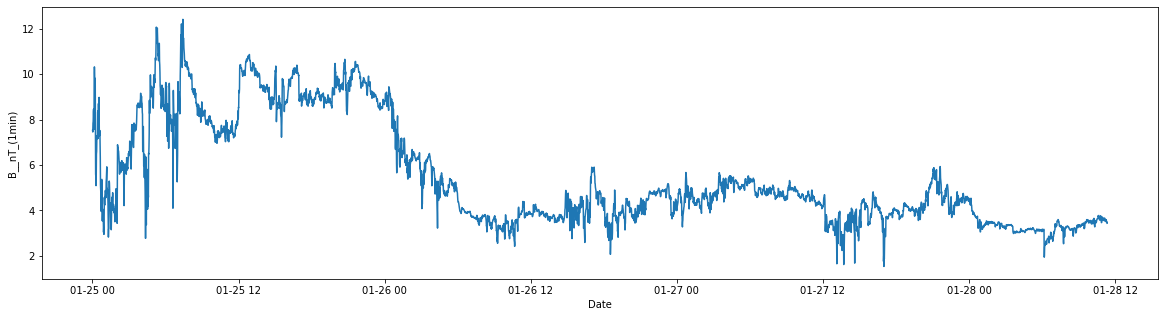

In [20]:
wind=wind.apply(pd.to_numeric, errors='coerce')
#After the error I received, I understood that it was not numerically and arranged the yield in this way.
ion=wind[:5000]
plt.figure(figsize=(20,5))
plt.xlabel("Date")
plt.ylabel("B__nT_(1min)")
plt.plot(ion["B__nT_(1min)"])



In [13]:
# Define LSTM model
def lstm_model(units, trainX, testX, y_train_tract1_array, y_test_tract1_array):
    model = Sequential()
    model.add(LSTM(units,return_sequences=True, input_shape=(trainX.shape[1],trainX.shape[2]),kernel_initializer='lecun_uniform'))
    model.add(Dropout(0.2))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(0.2))    
    model.add(LSTM(units))
    model.add(Dropout(0.2))
    model.add(Dense(1))        
    model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
    
    model.fit(trainX, y_train_tract1_array, batch_size=80, epochs=100, validation_data=(testX, y_test_tract1_array), verbose=0)
    return model

In [14]:
def england_temp_lstm(all_station_temp, lag, days):    
    
    seven_day_forecast_lstm = create_dates("2021-01-31 22:44:30+00:00" ,days) 
    
    for i in range(len(all_station_temp.columns)):
        
        # preprocessing
        station_value, station_name = get_value_name(all_station_temp,i)        
        train_tract1, test_tract1, split_row = train_test_split(station_value, station_name, 0.60)        
        train_tract1_scaled_df, test_tract1_scaled_df, scaler = data_transformation(train_tract1,test_tract1) 
        train_tract1 = timeseries_feature_builder(train_tract1_scaled_df, lag+1) 
        test_tract1 = timeseries_feature_builder(test_tract1_scaled_df, lag+1)               
        X_train_tract1_array, y_train_tract1_array, X_test_tract1_array, y_test_tract1_array = make_arrays(train_tract1, 
                                                                                                           test_tract1)        
        trainX = np.reshape(X_train_tract1_array, (X_train_tract1_array.shape[0],1,X_train_tract1_array.shape[1]))
        testX = np.reshape(X_test_tract1_array, (X_test_tract1_array.shape[0],1,X_test_tract1_array.shape[1]))                
        
        # LSTM modelling & forecast
        model = lstm_model(1, trainX, testX, y_train_tract1_array, y_test_tract1_array)             
        test_tract1_pred = valid_result(model, testX, y_test_tract1_array, scaler, station_value, split_row, lag)        
        seven_days = forecast(model, testX, test_tract1, lag, scaler, days)       
        seven_day_forecast_lstm[station_name] = np.array(seven_days)       
        
       
        # plot result
        plt.figure(figsize=(20,7))
        plt.plot(test_tract1_pred,label="actual")
        
        plt.plot(seven_day_forecast_lstm[station_name], color='red')
        plt.xlabel("Time Interval ")
        plt.ylabel(station_name)
        plt.legend( ["actual",'predicted','forecast'])
        plt.tight_layout()
       
    
        sns.despine(top=True)
        plt.subplots_adjust(left=0.1)
        plt.title(station_name+ " vs hours")
        plt.show()        
        print()
    return(seven_day_forecast_lstm)

B__nT_(1min) total samples:  10000
Training samples:  6000
Testing samples:  4000
Test R-squared is: -0.105889


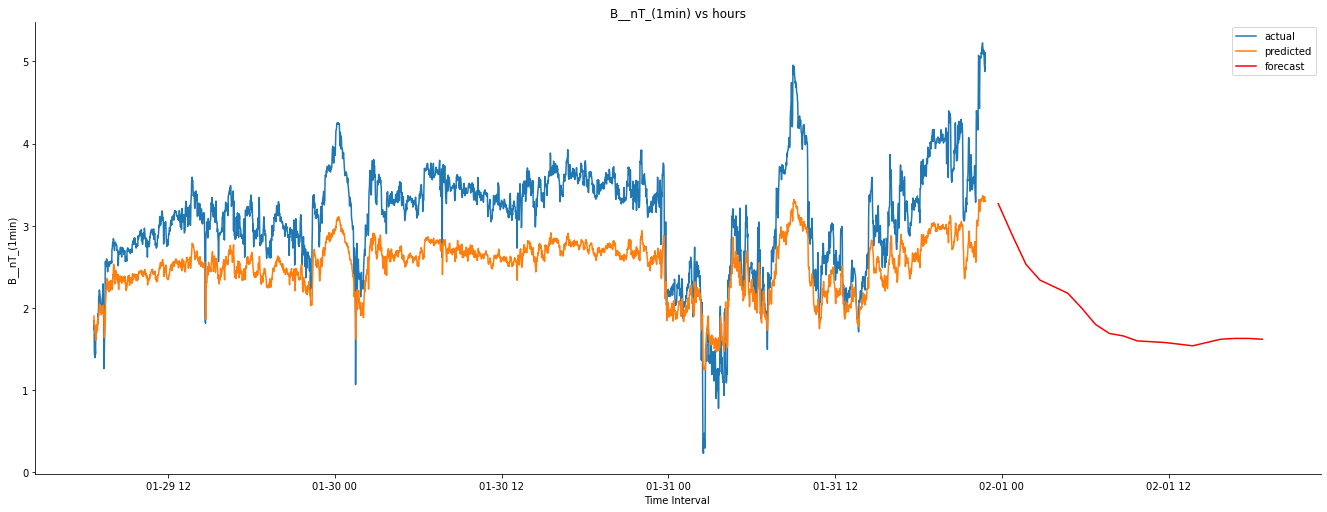


BX_(GSM)_(@_x-component_)_nT_(1min) total samples:  10000
Training samples:  6000
Testing samples:  4000
Test R-squared is: 0.575164


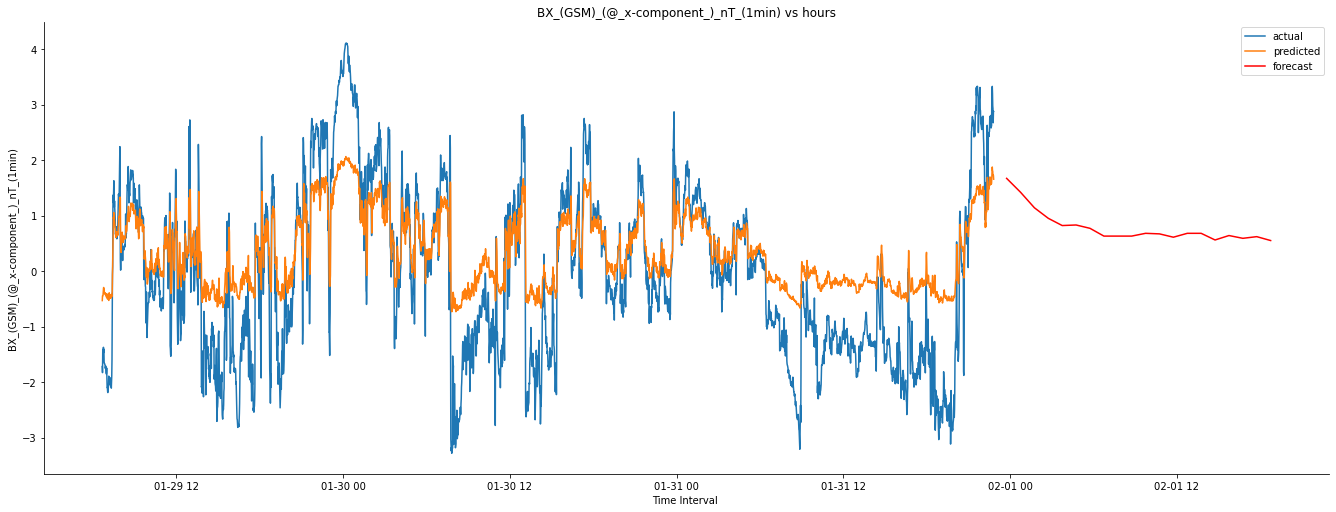


BY_(GSM)_(@_y-component_)_nT_(1min) total samples:  10000
Training samples:  6000
Testing samples:  4000
Test R-squared is: 0.544489


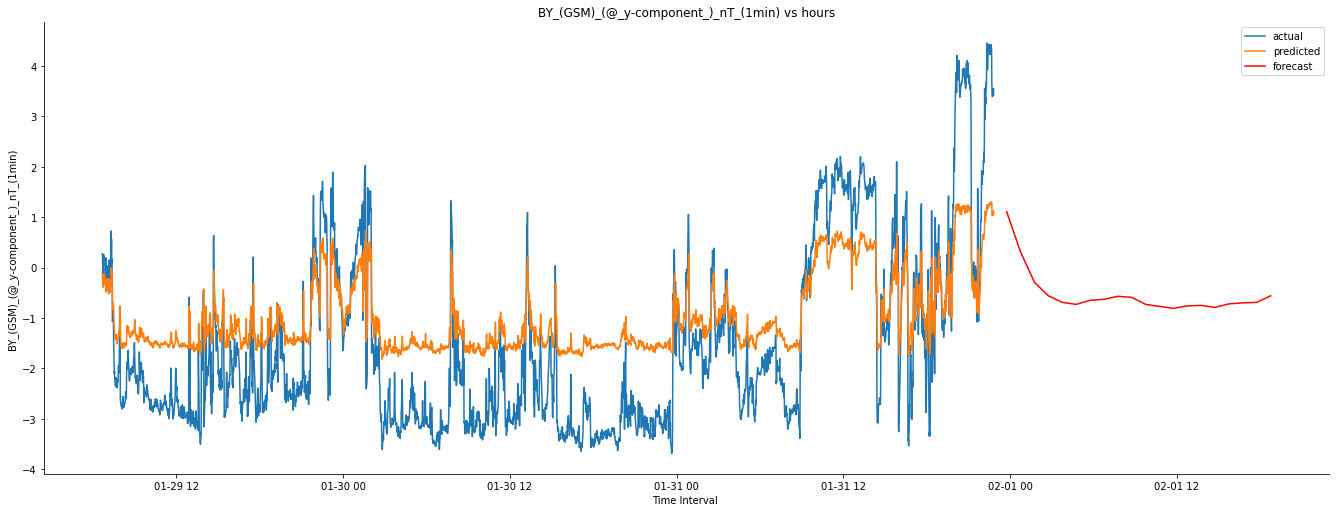


BZ_(GSM)_(@_z-component_)_nT_(1min) total samples:  10000
Training samples:  6000
Testing samples:  4000
Test R-squared is: 0.572457


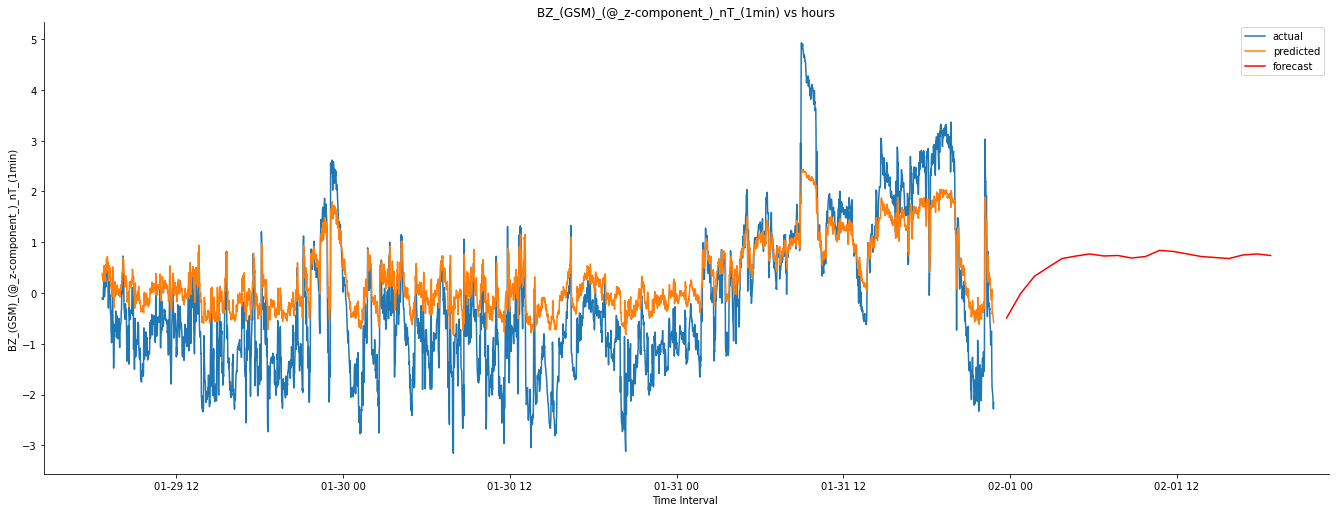


CPU times: user 2min 51s, sys: 19.6 s, total: 3min 10s
Wall time: 2min 10s


In [15]:
%%time
# Fitting and forecast using LSTM  -- output of train loss and valid loss is turned off
lstm_prediction = england_temp_lstm(wind,150,20)


In [21]:
spacenviroment=pd.read_excel(r"/Users/mertdil/Desktop/fiz437/PROJECT_FIZ437/Space Environment Project/SpaceEnvironment.xlsx",index_col=[0],parse_dates=[0])
spacenviroment


,SW_VTH_km/s,ION_NP_#/cc,VX_GMS_km/s,VY_GMS_km/s,VZ_GMS_km/s,SW_Kelvin
hh:mm:ss.ms,,,,,,
2021-01-26 09:01:24.000,37.6077,7.59894,-354.651,1.78827,6.660880,57114.926206
2021-01-26 09:03:02.111,35.9289,6.21697,-354.704,4.36227,-2.574700,52129.542623
2021-01-26 09:04:33.929,37.0247,6.44123,-353.158,-8.08718,3.050030,55357.844185
2021-01-26 09:06:17.992,40.0275,7.16111,-355.000,1.11376,4.174120,64701.299714
2021-01-26 09:07:59.128,30.8719,6.16921,-361.427,4.87481,-1.348760,38487.773673
...,...,...,...,...,...,...
2021-01-26 18:53:16.039,13.0597,8.63618,-343.965,-17.76200,-0.159306,6887.513670
2021-01-26 18:54:53.976,13.0484,8.77542,-344.299,-17.94800,0.562772,6875.599884
2021-01-26 18:56:31.914,13.1988,8.72823,-344.524,-16.85460,0.048157,7035.014042


SW_VTH_km/s total samples:  365
Training samples:  182
Testing samples:  183
Test R-squared is: -5.595206


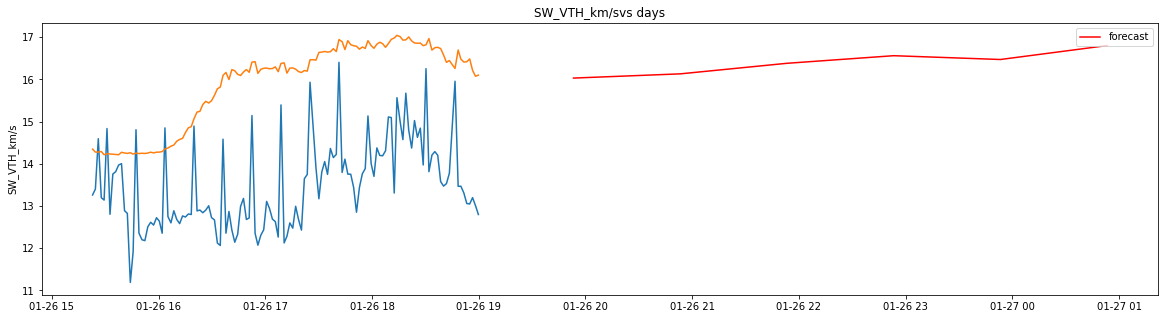


ION_NP_#/cc total samples:  365
Training samples:  182
Testing samples:  183
Test R-squared is: 0.297909


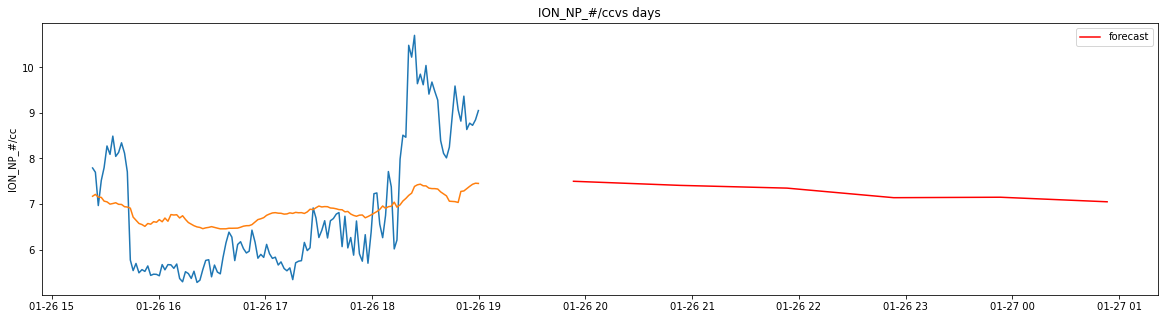


VX_GMS_km/s total samples:  365
Training samples:  182
Testing samples:  183
Test R-squared is: -0.002357


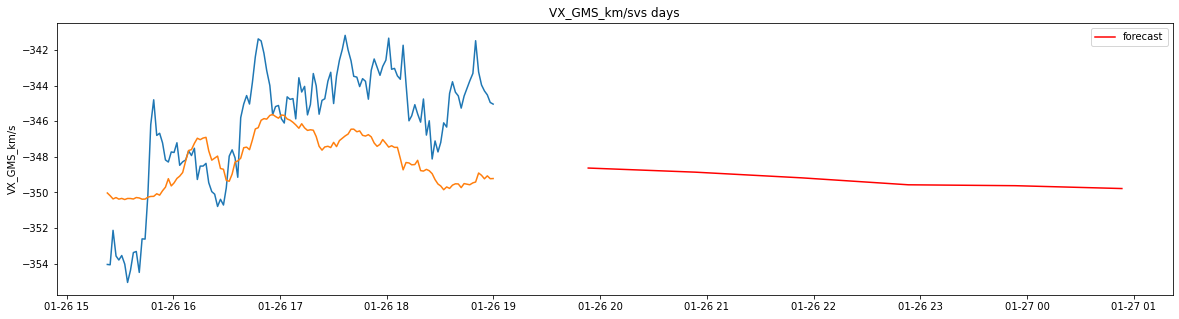


VY_GMS_km/s total samples:  365
Training samples:  182
Testing samples:  183
Test R-squared is: -5.237151


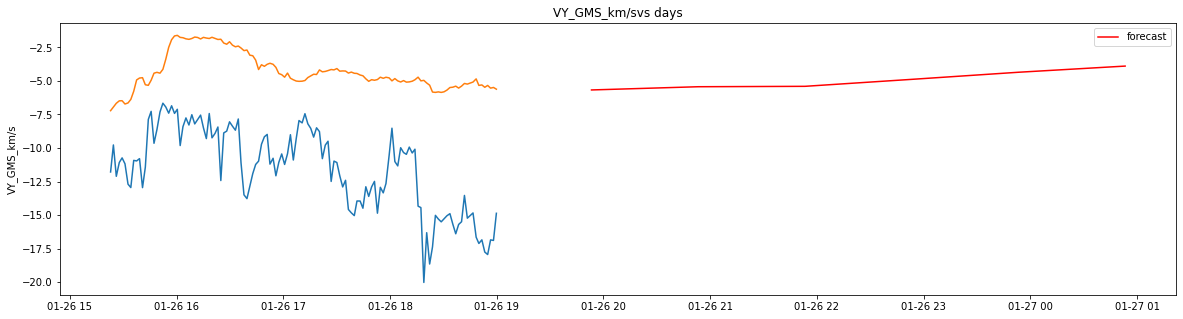


VZ_GMS_km/s total samples:  365
Training samples:  182
Testing samples:  183
Test R-squared is: 0.216320


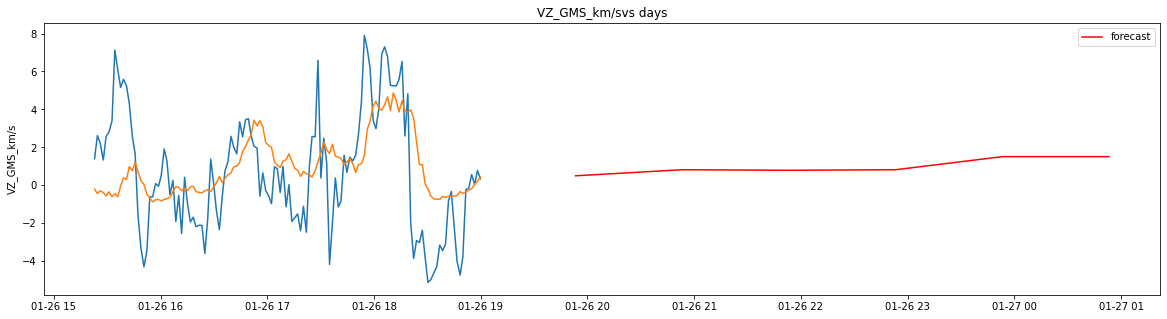


SW_Kelvin total samples:  365
Training samples:  182
Testing samples:  183
Test R-squared is: -8.418284


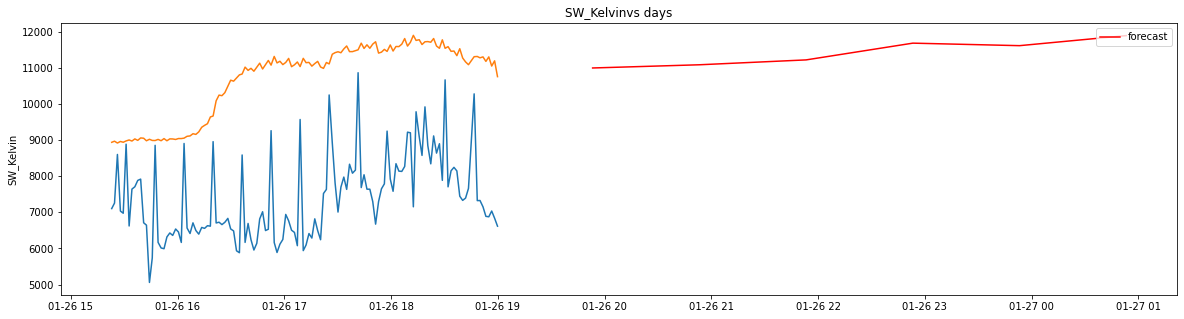


CPU times: user 1min 35s, sys: 6.99 s, total: 1min 42s
Wall time: 1min 27s


In [29]:
%%time
# Fitting and forecast using LSTM  -- output of train loss and valid loss is turned off
lstm_prediction = england_temp_lstm(spacenviroment,50,6)

In [30]:
table1=pd.read_excel(r"/Users/mertdil/Desktop/fiz437/PROJECT_FIZ437/Space Environment Project/Table-1.xlsx",index_col=[0],parse_dates=[0])
table1

,B_tot,B_x,B_y,B_z,ION_NP__#/cc,VX_(GSM)_(@_x_)_km/s,VX_(GSM)_(@_x_)_km/s2,VX_(GSM)_(@_x_)_km/s3,SW_Temp_Kelvin
Time,,,,,,,,,
2018-12-19 00:00:57.114000+00:00,3.862183,2.517290,0.207009,2.92179,5.25617,-435.432,8.64124,-0.963151,98019.353541
2018-12-19 00:02:29.114000+00:00,3.844573,2.663160,-0.320904,2.75415,4.96623,-428.476,20.48840,22.346400,91197.269786
2018-12-19 00:04:01.114000+00:00,4.055059,2.936420,-1.166250,2.54181,4.78599,-441.916,27.43030,6.348430,73123.066885
2018-12-19 00:05:33.114000+00:00,3.330727,2.446320,-0.422450,2.22054,4.59210,-447.990,38.52180,-0.956909,74329.856945
2018-12-19 00:07:05.114000+00:00,4.426582,1.632980,3.402230,2.31362,4.45827,-440.175,21.50120,3.473470,70420.374870
...,...,...,...,...,...,...,...,...,...
2018-12-19 21:55:01.106000+00:00,3.572578,1.427320,-2.854390,-1.60578,3.15434,-570.192,-1.02770,4.239360,111670.805834
2018-12-19 21:56:33.106000+00:00,3.563170,0.495486,-2.915640,-1.98739,3.19372,-580.617,29.55470,1.755360,94905.772377
2018-12-19 21:58:05.106000+00:00,4.819745,-1.167150,-3.237280,-3.37457,2.55854,-578.982,-25.58650,-2.353890,77978.608020


B_tot total samples:  862
Training samples:  431
Testing samples:  431
Test R-squared is: 0.234627


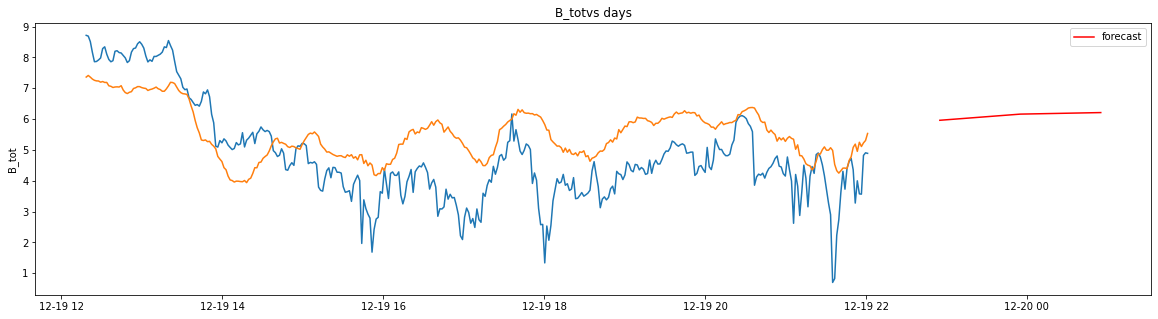


B_x total samples:  862
Training samples:  431
Testing samples:  431
Test R-squared is: 0.662977


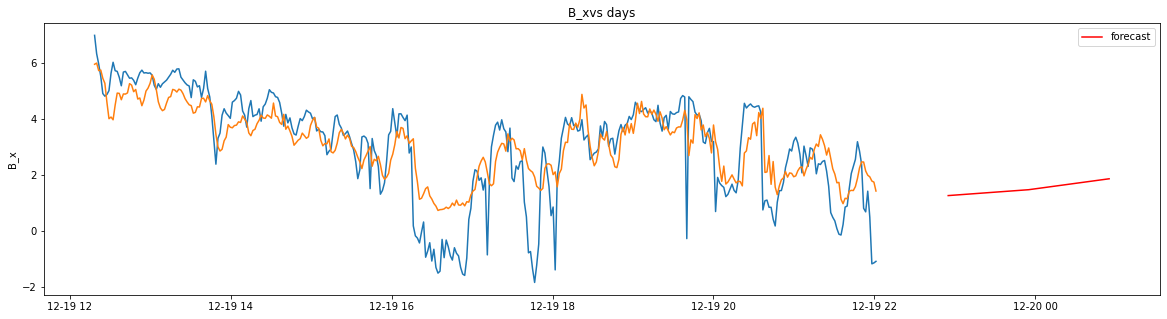


B_y total samples:  862
Training samples:  431
Testing samples:  431
Test R-squared is: 0.728357


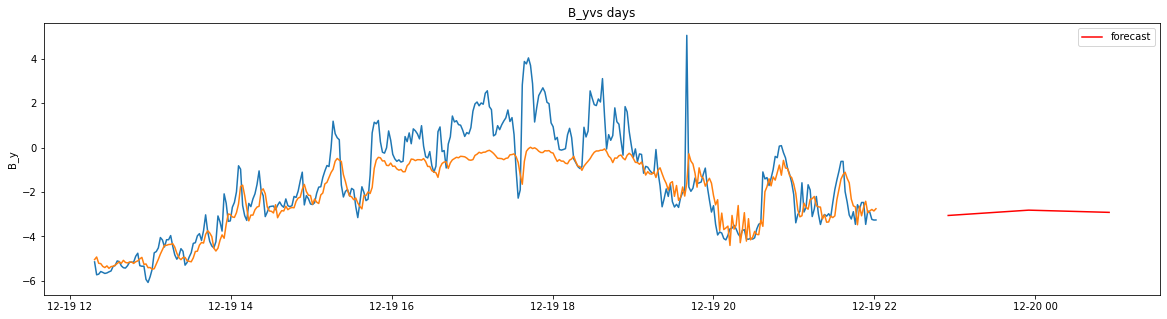


B_z total samples:  862
Training samples:  431
Testing samples:  431
Test R-squared is: 0.652086


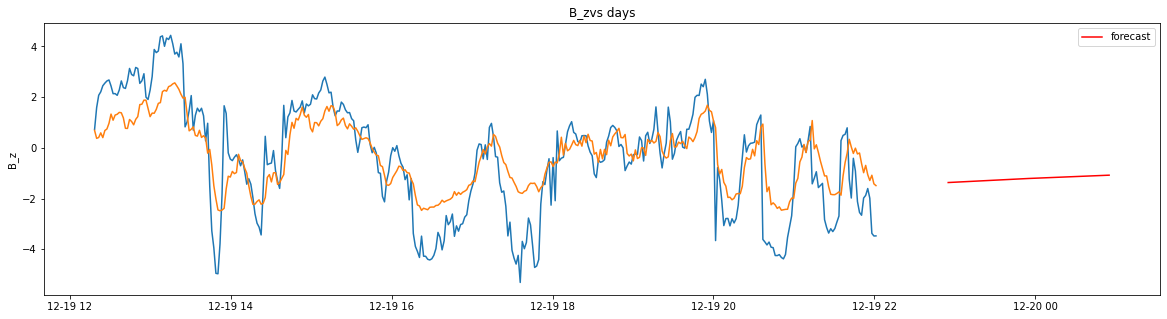


ION_NP__#/cc total samples:  862
Training samples:  431
Testing samples:  431
Test R-squared is: 0.380057


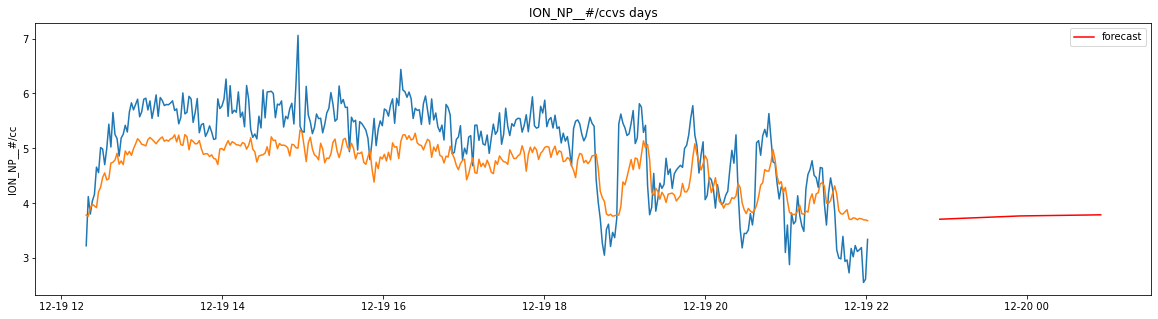


VX_(GSM)_(@_x_)_km/s total samples:  862
Training samples:  431
Testing samples:  431
Test R-squared is: 0.826874


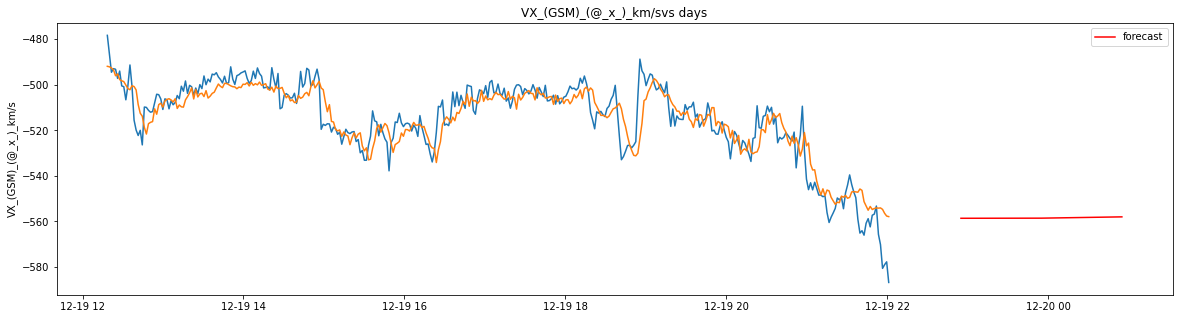


VX_(GSM)_(@_x_)_km/s2 total samples:  862
Training samples:  431
Testing samples:  431
Test R-squared is: 0.046600


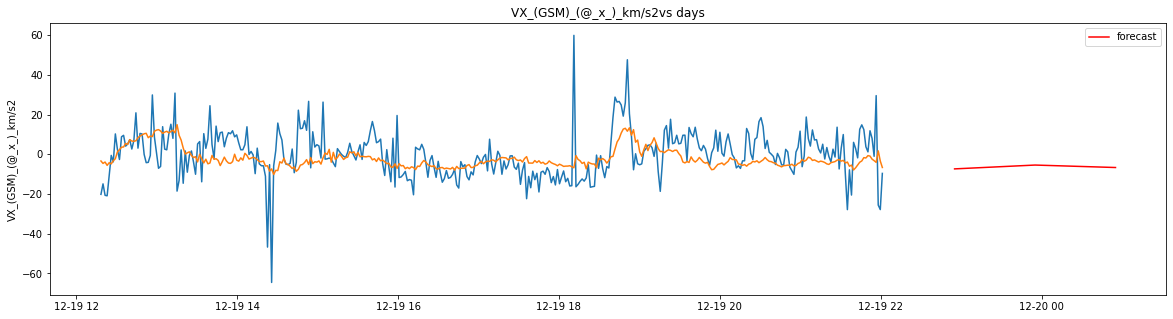


VX_(GSM)_(@_x_)_km/s3 total samples:  862
Training samples:  431
Testing samples:  431
Test R-squared is: -0.168644


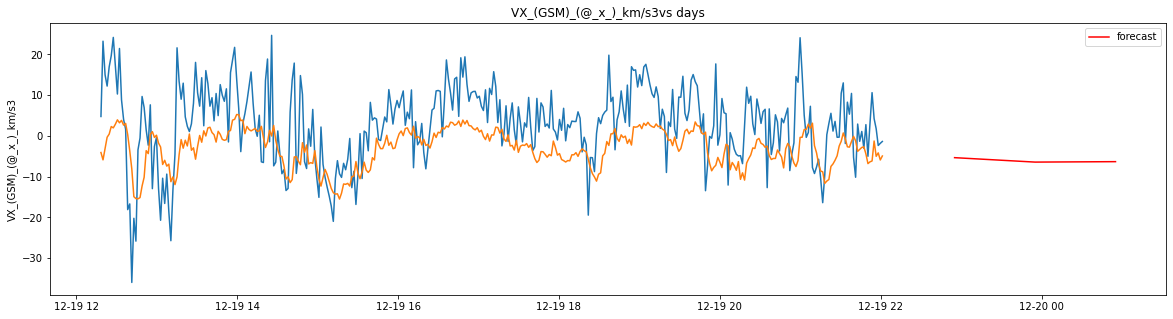


SW_Temp_Kelvin total samples:  862
Training samples:  431
Testing samples:  431
Test R-squared is: -0.461741


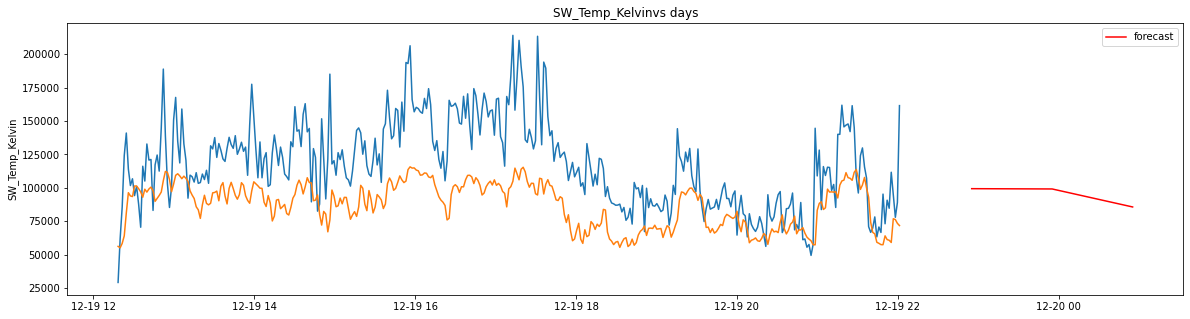


CPU times: user 3min 5s, sys: 16.4 s, total: 3min 21s
Wall time: 2min 38s


In [42]:
%%time
# Fitting and forecast using LSTM  -- output of train loss and valid loss is turned off
lstm_prediction = england_temp_lstm(table1,50,3)